# Checking to see if the noncoding sequence (NCS) length distributions match the coding sequence (CDS) length distributions.

## Import data

In [6]:
email = "vignesh.ravindranath@gmail.com"

import os
import sys
import numpy as np
from scipy.sparse import csr_matrix
from Bio import Entrez
Entrez.email = email
from matplotlib import pyplot as plt

import re
import itertools
import textwrap
import warnings

import pandas as pd
from scipy import stats
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation

In [2]:
START_CODONS = ['ATG','CTG','GTG','TTG']
STOP_CODONS = ['TAG','TGA','TAA']

'''
INPUT: name of text file (string) with accession numbers
OUTPUT: list of accession numbers
'''
def get_input_ids(filename):    
    try:
        open('./inputs/' + filename, 'r')
    except IOError:
        print("Error: File does not appear to exist. Try 'input_test', 'input_sm', 'input_med', or 'input_lg'.")
        return 0
    
    with open('./inputs/' + filename) as file:
        prok_ids = file.readlines()
        prok_ids = [line.rstrip() for line in prok_ids]
        
    return prok_ids

def preprocess_genome(filename, LMIN=60, OFFSET=30):
    # get input genome accession numbers
    prok_ids = get_input_ids(filename)    
    
    _cds, _ncs = [], []
    for acc_num in prok_ids:
        
        # GET GENOME USING ENTREZ
        try:
            seq_record = fetch_genome(acc_num)
            print(f'Successfully fetched {acc_num}')
        except Exception:
            print(f'Error: Invalid accession number: {acc_num}')
            continue
        
        # DEFINE DNA: CODING, NONCODING STRANDS
        dna = [seq_record, seq_record.reverse_complement()]                
        
        # FIND POS/NEG ORFS 
        cds, ncs = get_orfs(seq_record, dna, acc_num, LMIN=LMIN, OFFSET=OFFSET) 
        
        # SAVE DATA
        _cds.extend(cds)
        _ncs.extend(ncs)
        
        print(f'{len(cds)} CDS Records, {len(ncs)} NCS Records\n')
    
    print(f'{len(_cds)} Total CDS Records')
    print(f'{len(_ncs)} Total NCS Records')
    
    return _cds, _ncs

def fetch_genome(acc_num):
    # seq_records (features) from GenBank file
    handle = Entrez.efetch(db="sequences", id=acc_num, rettype="gbwithparts", retmode="text")
    seq_record = SeqIO.read(handle, "gb")
    handle.close()
    
    return seq_record


def get_orfs(seq_record, dna, acc_num, LMIN, OFFSET):
    # Get positive ORFs (coding sequences (CDS) or genes)
    cds = get_cds_records(seq_record, dna, acc_num, LMIN, OFFSET)
            
    # Find interregions
    interregions = get_interregions(cds, seq_record)
    
    # Get negative ORFs
    ncs = get_ncs_records(interregions, dna, acc_num, LMIN, OFFSET)
    
    return cds, ncs


def get_cds_records(seq_record, dna, acc_num, LMIN, OFFSET):
    cds = []
    for feature in seq_record.features:
        if feature.type == 'CDS':
            tag    = feature.qualifiers['locus_tag'][0]
            start  = feature.location.start.position
            end    = feature.location.end.position
            strand = feature.strand
            m30    = (dna[0][start-OFFSET:start] if strand == 1 else dna[1][::-1][end:end+OFFSET][::-1]).seq
            seq    = (dna[0][start:end] if strand == 1 else dna[1][::-1][start:end][::-1]).seq
            p30    = (dna[0][end:end+OFFSET] if strand == 1 else dna[1][::-1][start-OFFSET:start][::-1]).seq
            
            if len(seq) < LMIN: continue # check if orf length > l_min = 60
            
            f = [SeqFeature(FeatureLocation(start, end, strand), type='CDS')]
            r = SeqRecord(m30+seq+p30, name=tag, id=acc_num, features=f)            
            cds.append(r)
    
    return cds

# Copyright(C) 2009 Iddo Friedberg & Ian MC Fleming
# Released under Biopython license. http://www.biopython.org/DIST/LICENSE
# Do not remove this comment
def get_interregions(coding_records, seq_record):
    cds_list_plus = []
    cds_list_minus = []
    intergenic_records = []
    
    initials = coding_records[0].name[0:2]
    acc_num = seq_record.id

    # Loop over the genome file, get the CDS features on each of the strands
    for record in coding_records:
        feature = record.features[0]
        mystart = feature.location.start.position
        myend = feature.location.end.position
        if feature.strand == -1:
            cds_list_minus.append((mystart,myend,-1))
        elif feature.strand == 1:
            cds_list_plus.append((mystart,myend,1))
        else:
            sys.stderr.write("No strand indicated %d-%d. Assuming +\n" %(mystart, myend))
            cds_list_plus.append((mystart,myend,1))
    buffer = 0
    for i,pospair in enumerate(cds_list_plus[1:]):
        # Compare current start position to previous end position
        last_end = cds_list_plus[i][1]
        this_start = pospair[0]
        if this_start - last_end >= 1:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = +1
            name = initials + '_NC' + str(i).zfill(5)
            feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
            intergenic_records.append(SeqRecord(intergene_seq, name=name, id=acc_num, features=feature))
        count = i
    for i,pospair in enumerate(cds_list_minus[1:]):
        last_end = cds_list_minus[i][1]
        this_start = pospair[0]
        if this_start - last_end >= 1:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = -1
            name = initials + '_NC' + str(i+buffer).zfill(5)
            feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
            intergenic_records.append(SeqRecord(intergene_seq, name=name, id=acc_num, features=feature))
    return intergenic_records


def get_ncs_records(interregions, dna, acc_num, LMIN, OFFSET):
    ## interregion (i or intr)
    ## longest orf (long)
    
    ncs = []
    for interregion in interregions:
        feature = interregion.features[0]
        strand  = feature.strand
        
        # find longest orf in interregion
        i_start  = feature.location.start.position
        i_end    = feature.location.end.position
        intr_seq = dna[0][i_start:i_end] if strand == 1 else dna[1][::-1][i_start:i_end][::-1]
        long_orf = longest_orf(intr_seq.seq)
        
        if not long_orf: continue                       # check if orf exists 
        if long_orf[1] - long_orf[0] < LMIN: continue   # check if orf length > l_min = 60
        
        tag   = interregion.name
        start = i_start + long_orf[0]
        end   = i_start + long_orf[1]

        m_start = start - OFFSET
        m_end = end + OFFSET
        
        m30   = (dna[0][m_start:start] if strand == 1 else dna[1][::-1][end-1:m_end-1][::-1]).seq
        seq   = intr_seq[long_orf[0]:long_orf[1]].seq
        p30   = (dna[0][end:m_end] if strand == 1 else dna[1][::-1][m_start-1:start-1][::-1]).seq
        
        f = [SeqFeature(FeatureLocation(start, end, strand), type='NCS')]
        r = SeqRecord(m30+seq+p30, name=tag, id=acc_num, features=f)
        ncs.append(r)
    
    return ncs
        
        
def codon_pos(seq, codon_list):
    pos = []
    for codon in codon_list:
        matches = re.finditer(codon, str(seq))
        matches_positions = [match.start() for match in matches]
        pos.extend(matches_positions)
    return sorted(pos)


'''
Input: Bio.Seq.Seq
Output: returns start and end position of longest orf in a sequence
'''
def longest_orf(seq):
    all_starts = codon_pos(seq, START_CODONS)
    all_stops  = codon_pos(seq, STOP_CODONS)

    orfs = []
    found = False;            
    for s in all_starts:
        for e in all_stops[::-1]:
            if (e >= s) and ((e-s)%3 == 0):
                found = True; orfs = [s,e+3];
                break
        if found: break
            
    return orfs


'''
Input: Bio.Seq.Seq
Output: returns all in-frame start codons within an ORF sequence
'''
def orf_finder(seq):
    all_starts = codon_pos(seq, START_CODONS)
    all_stops  = codon_pos(seq, STOP_CODONS)

    # find all ORF
    orfs = []
    for s in all_starts:
        for e in all_stops:
            if (e >= s) and (s%3 == 0):
                orfs.append([s,e+3])
    return orfs

In [3]:
# preprocess_genome takes an input list of GenBank prokaryote ids
%time _cds, _ncs = preprocess_genome('input_test.txt')

Successfully fetched NC_005966
3241, 1757 CDS, NCS Records

Successfully fetched NC_003305
1876, 892 CDS, NCS Records

Successfully fetched NC_007413
5185, 3765 CDS, NCS Records

Successfully fetched NC_004842
955, 578 CDS, NCS Records

11257 Total CDS Records
6992 Total NCS Records
CPU times: user 7min 13s, sys: 2.78 s, total: 7min 16s
Wall time: 9min 23s


## Summary Statistics

In [10]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

In [40]:
def get_seq_len(records):
    lengths = []
    for record in records:
        lengths.append(len(record.seq))
    return lengths

cds_seq_lens = get_seq_len(_cds)
ncs_seq_lens = get_seq_len(_ncs)

In [104]:
def summary_stats(records, disp=True):
    s = stats.describe(np.array(records))
    
    if disp:
        print(f'N:\t{s.nobs}')
        print(f'minmax:\t{s.minmax}')
        print(f'mean:\t{round(s.mean,2)}')
        print(f'var:\t{round(s.variance,2)}')
        print(f'skew:\t{round(s.skewness,2)}')
    
    return s.nobs, s.minmax, s.mean, s.variance, s.skewness

In [182]:
def plot_hist(record1, record2, num_bins=1000, xlim=[0,10000], ylim=[0,300], title1="CDS", title2="NCS"):
    # Creating histogram
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.hist(record1, num_bins)
    ax2.hist(record2, num_bins)
    
    # Show plot
    ax1.title.set_text(title1)
    ax2.title.set_text(title2)
    ax1.set_xlim([xlim[0],xlim[1]])
    ax1.set_ylim([ylim[0],ylim[1]])
    ax2.set_xlim([xlim[0],xlim[1]])
    ax2.set_ylim([ylim[0],ylim[1]])
    plt.show()

### Summary stats raw data

In [41]:
summary_stats(cds_seq_lens)

N:	11257
minmax:	(129, 19806)
mean:	1058.56
var:	598803.02
skew:	4.13


In [24]:
summary_stats(ncs_seq_lens)

N:	6992
minmax:	(120, 47841)
mean:	2150.263300915332
var:	10988438.767881991
skew:	3.821990250946844


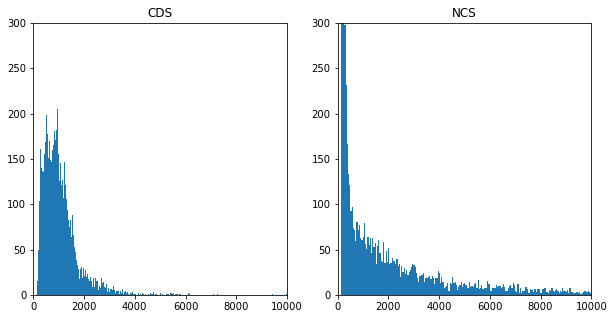

In [183]:
# raw data plots
plot_hist(cds_seq_lens, ncs_seq_lens)

### Normalized Data

In [129]:
def norm(records):
    _, mm, _, _, _ = summary_stats(records, disp=False)
    rng = mm[1] - mm[0]
    return [x/rng for x in records]

In [131]:
cds_norm = summary_stats(norm(cds_seq_lens))

N:	11257
minmax:	(0.006555877420338466, 1.0065558774203385)
mean:	0.05
var:	0.0
skew:	4.13


In [132]:
ncs_norm = summary_stats(norm(ncs_seq_lens))

N:	6992
minmax:	(0.0025146162067014523, 1.0025146162067013)
mean:	0.05
var:	0.0
skew:	3.82


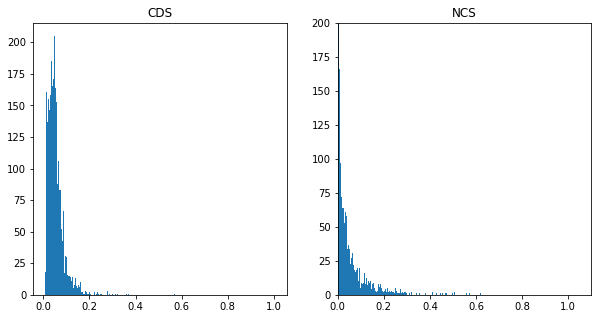

In [160]:
# normalized data plots
plot_hist(norm(cds_seq_lens), norm(ncs_seq_lens), xlim=[0,1.1], ylim=[0,200])

### Log Normalized Data

In [ ]:
from math import log

def log_norm(records):
    return [log(x) for x in norm(records)]

In [141]:
cds_log_norm = summary_stats(log_norm(cds_seq_lens))

N:	11257
minmax:	(-5.027393315600173, 0.006534481119402837)
mean:	-3.12
var:	0.4
skew:	-0.03


In [142]:
ncs_log_norm = summary_stats(log_norm(ncs_seq_lens))

N:	6992
minmax:	(-5.9856350887844245, 0.002511459849611648)
mean:	-4.0
var:	1.88
skew:	0.24


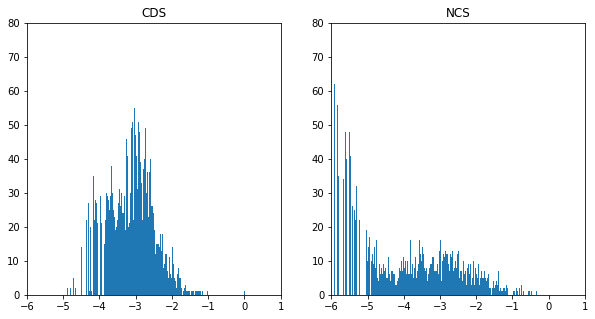

In [184]:
# log normal plots
plot_hist(log_norm(cds_seq_lens), log_norm(ncs_seq_lens), xlim=[-6,1], ylim=[0,80])

### Boxcox - square root

In [221]:
def boxcox(records, l=0.5):
    # l = -1.0 - reciprocal
    # l = -0.5 - reciprocal square root
    # l = 0.0  - log normal
    # l = 0.5  - square root
    # l = 1.0  - no transform
    return stats.boxcox(records, l)

In [222]:
cds_boxcox = summary_stats(boxcox(cds_seq_lens))

N:	11257
minmax:	(20.71563338320109, 279.46758250285245)
mean:	59.91
var:	401.64
skew:	1.21


In [223]:
ncs_boxcox = summary_stats(boxcox(ncs_seq_lens))

N:	6992
minmax:	(19.90890230020664, 435.45171162083693)
mean:	73.13
var:	2956.92
skew:	1.44


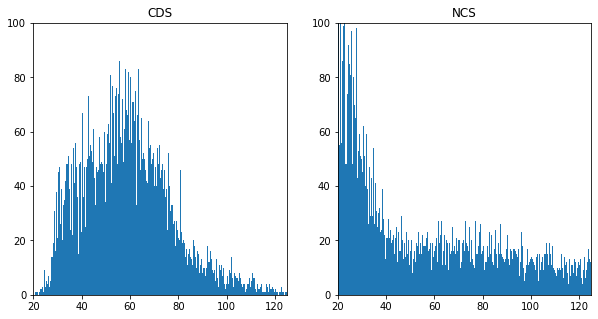

In [224]:
plot_hist(boxcox(cds_seq_lens), boxcox(ncs_seq_lens), xlim=[20,125], ylim=[0,100])
# plot_hist(boxcox(cds_seq_lens,l=-0.5), boxcox(ncs_seq_lens,l=-0.5), xlim=[1.8,2], ylim=[0,80])

## Normality Check

In [190]:
# normality test
def shapiro_test(records, alpha=0.05):
    # shapiro test
    stat, p = stats.shapiro(records)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [164]:
shapiro_test(norm(cds_norm_lens))

Statistics=0.750, p=0.000
Sample does not look Gaussian (reject H0)


In [165]:
shapiro_test(log_norm(cds_norm_lens))

Statistics=0.995, p=0.000
Sample does not look Gaussian (reject H0)


In [219]:
shapiro_test(boxcox(cds_norm_lens, l=0.5))

Statistics=0.940, p=0.000
Sample does not look Gaussian (reject H0)


In [193]:
def anderson_test(records):
    # normality test
    result = stats.anderson(records)
    print('Statistic: %.3f' % result.statistic)
    
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [199]:
anderson_test(norm(cds_seq_lens))

Statistic: 461.043
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [201]:
anderson_test(log_norm(cds_seq_lens))

Statistic: 20.113
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [218]:
anderson_test(boxcox(cds_seq_lens, l=0.5))

Statistic: 84.398
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


So the data is not normal. But the log-normal is closest to a normal distribution, so I will assume 

# More rigorous approach to fitting distribution to data

Ref: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

In [226]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [235]:
# Load data from statsmodels datasets
data = pd.Series(cds_seq_lens)

# # Plot for comparison
# plt.figure(figsize=(12,8))
# ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# # Save plot limits
# dataYLim = ax.get_ylim()
dataYLim = 20000

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

  1 / 101: ksone
  2 / 101: kstwo
  3 / 101: kstwobign
  4 / 101: norm
  5 / 101: alpha
  6 / 101: anglit
  7 / 101: arcsine
  8 / 101: beta
  9 / 101: betaprime
 10 / 101: bradford
 11 / 101: burr
 12 / 101: burr12
 13 / 101: fisk
 14 / 101: cauchy
 15 / 101: chi
 16 / 101: chi2
 17 / 101: cosine
 18 / 101: dgamma
 19 / 101: dweibull
 20 / 101: expon
 21 / 101: exponnorm
 22 / 101: exponweib
 23 / 101: exponpow
 24 / 101: fatiguelife
 25 / 101: foldcauchy
 26 / 101: f
 27 / 101: foldnorm
 28 / 101: weibull_min
 29 / 101: weibull_max
 30 / 101: genlogistic
 31 / 101: genpareto
 32 / 101: genexpon
 33 / 101: genextreme
 34 / 101: gamma
 35 / 101: erlang
 36 / 101: gengamma
 37 / 101: genhalflogistic
 38 / 101: gompertz
 39 / 101: gumbel_r
 40 / 101: gumbel_l
 41 / 101: halfcauchy
 42 / 101: halflogistic
 43 / 101: halfnorm
 44 / 101: hypsecant
 45 / 101: gausshyper
 46 / 101: invgamma
 47 / 101: invgauss
 48 / 101: geninvgauss
 49 / 101: norminvgauss
 50 / 101: invweibull
 51 / 101: joh

/home/viggyravi/anaconda3/envs/genpred/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2736: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(1.91276919).
  warnings.warn(


Text(0, 0.5, 'Frequency')

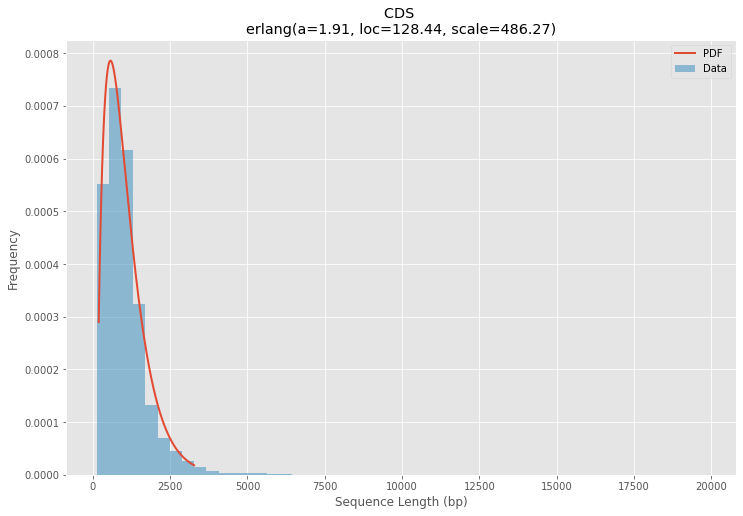

In [236]:
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'CDS.\n All Fitted Distributions')
ax.set_xlabel(u'Sequence Length (bp)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'CDS \n' + dist_str)
ax.set_xlabel(u'Sequence Length (bp)')
ax.set_ylabel('Frequency')

In [300]:
best_dist[1][0]

(1.9127691861956873, 128.44369531948115, 486.26774691064713)

In [397]:
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.erlang.html
import random

a     = best_dist[1][0]
loc   = best_dist[1][1]
scale = best_dist[1][2]


x = 150 # sequence of length x bp
r = random.randint(0,1000)
r * stats.erlang.pdf(x, a=a, loc=loc, scale=scale)

0.10406794210266201

In [305]:
int(stats.erlang.mean(1.91, 128.44, 486.26))

1057

# Create probability distribution to add NCS

In [3]:
def get_seq_len(records):
    lengths = []
    for record in records:
        lengths.append(len(record.seq))
    return lengths

def fit_erlang_dist(cds_records):
    params = None
    
    # Try to fit erlang distribution
    data = pd.Series(get_seq_len(cds_records))
    distribution = stats.erlang
    try:
        # Ignore warnings from data that can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')

            # fit dist to data
            params = distribution.fit(data)
        
    except Exception:
        print("Error: Not able to fit Erlang distribution to CDS data.")
        print("Will use approximate parameters instead: a=1.91, loc=128.44, scale=486.27. See EXAMPLE-NCS_LENGTH.ipynb for more details.")
        params = (1.91, 128.44, 486.27)
    
    return params

In [23]:
def perlang(x, a, loc, scale):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return random.randint(0,1000) * stats.erlang.pdf(x, a=a, loc=loc, scale=scale)
    
def get_ncs_records2(interregions, dna, acc_num, params, THRESHOLD, LMIN, OFFSET):
    ## interregion (i or intr)
    ## longest orf (long)
    
    ncs = []
    for i,interregion in enumerate(interregions):
        feature = interregion.features[0]
        strand  = feature.strand
        
        # find longest orf in interregion
        i_start  = feature.location.start.position
        i_end    = feature.location.end.position
        intr_seq = dna[0][i_start:i_end] if strand == 1 else dna[1][::-1][i_start:i_end][::-1]
        
        # get all possible orfs from interregion
        all_orfs = orf_finder(intr_seq.seq)
        
        # check if orfs exist
        if not all_orfs: continue
        
        # check if each orf falls in erlang distribution
        count = 1
        last_stop = all_orfs[0][1]
        for j,orf in enumerate(all_orfs[1:]):
            x = orf[1] - orf[0]
            
            # check if orf length > l_min = 60
            if x < LMIN: continue         
            
            if orf[1] != last_stop:
                count += 1
                last_stop = orf[1]            
            
            # try getting 1 valid ORF from each ORF-family (same stop codon)
            
#             # check probability of sequence occuring
#             # ensures NCS follows same distribution as CDS
#             prob = perlang(x, a=params[0], loc=params[1], scale=params[2])
            
#             if prob > THRESHOLD:
#                 count += 1
                
#                 tag   = interregion.name + "." + str(j)
#                 start = i_start + orf[0]
#                 end   = i_start + orf[1]

#                 m_start = start - OFFSET
#                 m_end = end + OFFSET

#                 m30   = (dna[0][m_start:start] if strand == 1 else dna[1][::-1][end-1:m_end-1][::-1]).seq
#                 seq   = intr_seq[orf[0]:orf[1]].seq
#                 p30   = (dna[0][end:m_end] if strand == 1 else dna[1][::-1][m_start-1:start-1][::-1]).seq

#                 f = [SeqFeature(FeatureLocation(start, end, strand), type='NCS')]
#                 r = SeqRecord(m30+seq+p30, name=tag, id=acc_num, features=f)
#                 ncs.append(r)
                
        print(f'Interregion {i}\t, n_orfs {len(all_orfs)}\t, n_stops {count}')
    
    return ncs

In [7]:
# constants
LMIN = 60
OFFSET = 30

# get first prok genome accession number
prok_ids = get_input_ids('input_test.txt')    
acc_num = prok_ids[0]

# fetch genome
seq_record = fetch_genome(acc_num)
dna = [seq_record, seq_record.reverse_complement()]

# find CDS
cds = get_cds_records(seq_record, dna, acc_num, LMIN, OFFSET)
print(len(cds))

# find interregions
interregions = get_interregions(cds, seq_record)
print(len(interregions))

# fit data to erlang distribution
params = fit_erlang_dist(cds)
print(params)

2478
1799
(1.8635386861200218, 138.8793721399076, 396.4360589653121)


In [24]:
# find NCS
ncs = get_ncs_records2(interregions, dna, acc_num, params, THRESHOLD=0.50, LMIN=LMIN, OFFSET=OFFSET)
print(len(ncs))

Interregion 0	, n_orfs 51	, n_stops 36
Interregion 2	, n_orfs 6	, n_stops 1
Interregion 3	, n_orfs 5	, n_stops 0
Interregion 7	, n_orfs 1	, n_stops 0
Interregion 15	, n_orfs 11436	, n_stops 11148
Interregion 16	, n_orfs 1	, n_stops 0
Interregion 17	, n_orfs 1787	, n_stops 1670
Interregion 19	, n_orfs 214	, n_stops 187
Interregion 21	, n_orfs 692	, n_stops 639
Interregion 24	, n_orfs 1515	, n_stops 1437
Interregion 26	, n_orfs 1	, n_stops 0
Interregion 27	, n_orfs 1072	, n_stops 1001
Interregion 28	, n_orfs 2853	, n_stops 2745
Interregion 29	, n_orfs 374	, n_stops 328
Interregion 30	, n_orfs 2646	, n_stops 2555
Interregion 31	, n_orfs 39879	, n_stops 39336
Interregion 32	, n_orfs 46	, n_stops 34
Interregion 34	, n_orfs 182	, n_stops 158
Interregion 36	, n_orfs 570	, n_stops 487
Interregion 37	, n_orfs 6279	, n_stops 6105
Interregion 38	, n_orfs 1	, n_stops 0
Interregion 39	, n_orfs 24634	, n_stops 24273
Interregion 40	, n_orfs 317	, n_stops 277
Interregion 41	, n_orfs 346	, n_stops 315


In [ ]:
plot_hist(get_seq_len(cds), get_seq_len(ncs))